In [1]:
%matplotlib inline
from os import listdir
from os.path import isfile, join
import numpy as np
from glob import glob
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib
import statsmodels.stats.multitest as smt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from adjustText import adjust_text
from scipy import stats
from venn import venn
import itertools

from scipy.stats import fisher_exact

In [2]:
def read_degenotate_mk(dir_path, file_name):
    
    ## Reads Degenotate MK table into a dict
    file_data = glob(dir_path + file_name)[0]
    df = pd.read_csv(file_data, sep='\t')
    df['standard_alpha'] = 1 - df['mk.odds.ni']
    mk_dict = df.set_index('gene').transpose().to_dict()
    return mk_dict

In [3]:
def compute_standard_MKT(p, p0, d, d0):
    
    ## calculates standard alpha and DoS
    try:
        standard_alpha = 1 - p / p0 * d0 / d
    except ZeroDivisionError:
        standard_alpha = 'NA'
    try:
        standard_dos = d / (d + d0) - p / (p + p0)
    except ZeroDivisionError:
        standard_dos = 'NA'
    return standard_alpha, standard_dos


def compute_extended_MKT(d, d0, p_high, p0_high):
    
    ## calculates extended alpha and DoS
    try:
        ext_alpha = 1 - p_high / p0_high * d0 / d
    except ZeroDivisionError:
        ext_alpha = 'NA'
    try:
        ext_dos = d / (d + d0) - p_high / (p_high + p0_high)
    except ZeroDivisionError:
        ext_dos = 'NA'
    return ext_alpha, ext_dos


def compute_imputed_MKT(p, p0, d, d0, p_high, p0_high, p_low, p0_low):
    
    ## calculates imputed alpha and DoS
    try:
        p_wd = p_low - p_high / p0_high * p0_low
        imp_alpha = 1 - (p - p_wd) / p0 * d0 / d
    except ZeroDivisionError:
        imp_alpha = 'NA'
    try:
        p_wd = p_low - p_high / p0_high * p0_low
        imp_dos = d / (d + d0) - (p - p_wd) / ((p - p_wd) + p0)
        imp_odds, imp_pval = fisher_exact([[(p - p_wd), p0], [d, d0]])
    except ZeroDivisionError:
        imp_dos = 'NA'
        imp_pval = 'NA'
    return imp_alpha, imp_dos, imp_pval

In [4]:
## number of alleles
N = 2 * 10

def run_all_mkt(mk_dict, cutoff):
    
    ## Updates provided mk dictionary with MKT extension stats
    for g in mk_dict:
        try:
            pN_list = [float(i) for i in mk_dict[g]['af_nonsyn'].split('|')]
        except AttributeError:
            pN_list = []
        try:
            pS_list = [float(i) for i in mk_dict[g]['af_syn'].split('|')]
        except AttributeError:
            pS_list = []

        ## remove singletons
        p  = len([i for i in pN_list if i > 1/N])
        p0 = len([i for i in pS_list if i > 1/N])
        d  = mk_dict[g]['dN']
        d0 = mk_dict[g]['dS']

        ## calculate standard alpha and DoS
        standard_alpha, standard_dos = compute_standard_MKT(p, p0, d, d0)

        ## calculate extended alpha and DoS
        pN_af_high = [i for i in pN_list if i > cutoff - .05]
        pS_af_high = [i for i in pS_list if i > cutoff - .05]
        p_high  = len(pN_af_high)
        p0_high = len(pS_af_high)
        ext_alpha, ext_dos = compute_extended_MKT(d, d0, p_high, p0_high)

        ## calculate imputed alpha and DoS
        pN_af_high = [i for i in pN_list if i > cutoff]
        pN_af_low  = [i for i in pN_list if (i < cutoff) & (i > 1/N)]
        pS_af_high = [i for i in pS_list if i > cutoff]
        pS_af_low  = [i for i in pS_list if (i < cutoff) & (i > 1/N)]
        p_high  = len(pN_af_high)
        p0_high = len(pS_af_high)
        p_low   = len(pN_af_low)
        p0_low  = len(pS_af_low)
        imp_alpha, imp_dos, imp_pval = compute_imputed_MKT(p, p0, d, d0, p_high, p0_high, p_low, p0_low)

        ## update gene dictionary with new MKT statistics 
        mk_dict[g]['standard_alpha'] = standard_alpha
        mk_dict[g]['standard_dos'] = standard_dos
        mk_dict[g]['ext_alpha'] = ext_alpha
        mk_dict[g]['ext_dos'] = ext_dos
        mk_dict[g]['imp_alpha'] = imp_alpha
        mk_dict[g]['imp_dos'] = imp_dos
        mk_dict[g]['imp_pval'] = imp_pval
    return mk_dict

In [6]:
### Perform standard, extended, and imputed MKT

# dbs = ['vidMac', 'vidCha', 'indInd', 'anoImb', 'molAte', 'agePho', 'picPub']
# dbs = ['agePho', 'vidMac', 'vidCha', 'indInd', 'anoImb']
dbs = ['agePho']
dir_path = '/Users/osipova/Documents/LabDocs/Brood_parasites_analysis/'

all_DFs = {}
i = 0
cutoff = 0.15

for db in dbs:
    ## Read data for each gene with syn/nonsyn AF
    print(db)
    file_name = 'MK_test_{}_ncbi/af.gene.longest.mk.tsv'.format(db)
    mk_dict = read_degenotate_mk(dir_path, file_name)
    all_DFs[db] = mk_dict
    
    ## Perform three MKT extensions
    mk_dict_extended = run_all_mkt(mk_dict, cutoff)
    
    ## Write an updated MKT dataframe into a file
    out_file = 'MK_test_{}_ncbi/extended.af.gene.longest.mk.tsv'.format(db)
    df_mkt = pd.DataFrame.from_dict(mk_dict_extended, orient='index')
    df_mkt.index.name = 'gene'
    df_mkt.to_csv(out_file, sep='\t')
    

agePho


In [9]:
dfi = all_DFs['agePho']

In [13]:
dfi

{'PTH1R': {'transcript': 'XM_054643637.1',
  'af_nonsyn': nan,
  'af_syn': '0.05|0.05|0.05|0.05|0.05|0.05|0.05|0.05|0.4|0.05|0.15|0.05|0.05',
  'pN': 0.0,
  'pS': 2.0,
  'dN': 0.0,
  'dS': 1.0,
  'mk.raw.p.value': 1.0,
  'mk.odds.ni': nan,
  'dos': 0.0,
  'standard_alpha': 'NA',
  'standard_dos': 0.0,
  'ext_alpha': 'NA',
  'ext_dos': 0.0,
  'imp_alpha': 'NA',
  'imp_dos': 0.0,
  'imp_pval': 1.0},
 'CCDC12': {'transcript': 'XM_054633519.1',
  'af_nonsyn': '0.05|0.05|0.15|0.05',
  'af_syn': '0.05|0.05|0.25|0.05|0.05|0.6|0.1|0.05',
  'pN': 1.0,
  'pS': 3.0,
  'dN': 0.0,
  'dS': 0.0,
  'mk.raw.p.value': 1.0,
  'mk.odds.ni': nan,
  'dos': nan,
  'standard_alpha': 'NA',
  'standard_dos': 'NA',
  'ext_alpha': 'NA',
  'ext_dos': 'NA',
  'imp_alpha': 'NA',
  'imp_dos': 'NA',
  'imp_pval': 'NA'},
 'NBEAL2': {'transcript': 'XM_054641176.1',
  'af_nonsyn': '0.15|0.05|0.1|0.2|0.05|0.05|0.056|0.278|0.1|0.05|0.3|0.1|0.05|0.05|0.85|0.05|0.1|0.15|0.2|0.05|0.05|0.15|0.25|0.05|0.85|0.05|0.4|0.05|0.05|0.

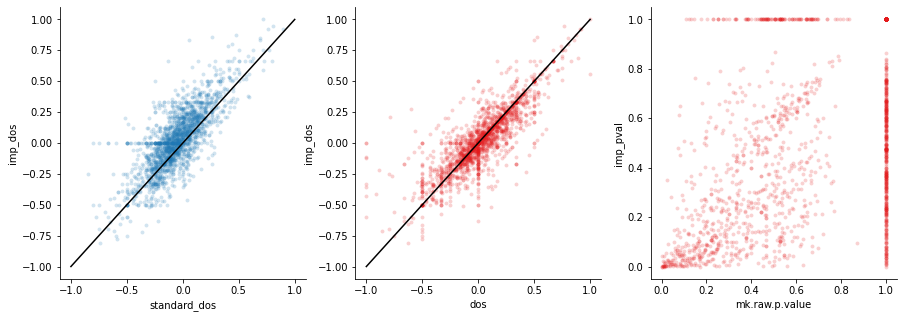

In [192]:
### Check correlation between standard, extended, and imputed DoS
df_mkt = pd.DataFrame.from_dict(mk_dict, orient='index')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
ax1, ax2, ax3 = axes[0], axes[1], axes[2]
p = sns.color_palette('Paired')
pal = p[1], p[5]

not_na_df = df_mkt[(df_mkt['ext_dos'] != 'NA') &
                   (df_mkt['imp_dos'] != 'NA')]

sns.scatterplot(ax=ax1, data=not_na_df, x='standard_dos', y='imp_dos',
                linewidth=0, s=15, color=pal[0], alpha=0.2)
sns.scatterplot(ax=ax2, data=not_na_df, x='dos', y='imp_dos',
                linewidth=0, s=15, color=pal[1], alpha=0.2)
sns.scatterplot(ax=ax3, data=not_na_df, x='mk.raw.p.value', y='imp_pval',
                linewidth=0, s=15, color=pal[1], alpha=0.2)

sns.lineplot(ax=ax1, x=[-1, 1], y=[-1, 1], color='black', dashes=True)
sns.lineplot(ax=ax2, x=[-1, 1], y=[-1, 1], color='black', dashes=True)

# sns.lineplot(ax=ax3, x=[-1, 1], y=[-1, 1], color='black', dashes=True)
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)

KeyError: 'vidMac'

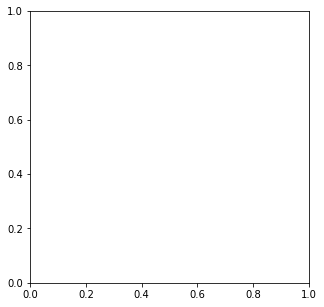

In [8]:
DNs = {}
DSs = {}
for db in dbs:
    mk_dict = all_DFs[db]
    db_dn = [mk_dict[g]['dN'] for g in mk_dict ]
    db_ds = [mk_dict[g]['dS'] for g in mk_dict ]
    DNs[db] = db_dn
    DSs[db] = db_ds

fig, axes = plt.subplots(figsize=(5, 5))
p = sns.color_palette('Set2', n_colors=4)

sns.histplot(DNs['vidMac'], binwidth=1, kde=True, alpha = 0.3, multiple="dodge", color=p[0])
# sns.histplot(DNs['vidCha'], binwidth=1, kde=True, alpha = 0.3, multiple="dodge", color=p[1])
# sns.histplot(DNs['indInd'], binwidth=1, kde=True, alpha = 0.3, multiple="dodge", color=p[2])
sns.histplot(DNs['anoImb'], binwidth=1, kde=True, alpha = 0.3, multiple="dodge", color=p[3])
axes.set_xlim(0, 20)
# axes.set_ylim(1, 5000)

sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)

In [12]:
dir_path = '/Users/osipova/Documents/LabDocs/Brood_parasites_analysis/'
file_name = 'abc_alph_estimates.3bp.tsv'
file_data = glob(dir_path + file_name)[0]
df = pd.read_csv(file_data, sep='\t')
df.head()

,alpha,db,test,class
0,0.098,vidCha,oxphos,alpha
1,-0.020,vidCha,oxphos,alpha
2,0.697,vidCha,oxphos,alpha
3,0.566,vidCha,control,alpha
4,0.286,vidCha,control,alpha


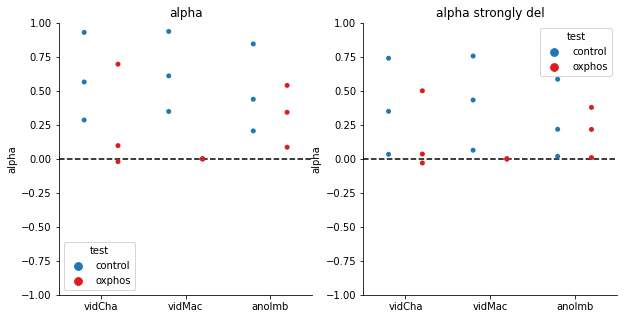

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax1, ax2 = axes[0], axes[1]

p = sns.color_palette('Paired')
pal = p[1], p[5]

sns.stripplot(ax=ax1, data=df[df['class']=='alpha'], x='db', y='alpha', hue='test', 
              jitter=0, dodge=True, hue_order=['control', 'oxphos'], palette=pal)
sns.stripplot(ax=ax2, data=df[df['class']=='alpha_strong'], x='db', y='alpha', hue='test', 
              jitter=0, dodge=True, hue_order=['control', 'oxphos'], palette=pal)

ax1.set_title('alpha')
ax2.set_title('alpha strongly del')
ax1.axhline(y=0, ls='--', color='k')
ax2.axhline(y=0, ls='--', color='k')
ax1.set_ylim(-1,1)
ax2.set_ylim(-1,1)
ax1.set_xlabel('')
ax2.set_xlabel('')
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)

pdf_name = 'abc_alpha_estimates.3bp.v1.pdf'
# fig.savefig(pdf_name, bbox_inches='tight')

In [5]:
all_DFs

NameError: name 'all_DFs' is not defined